In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Matplotlib style
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False
sns.set(style="whitegrid")

print("[OK] Libraries imported.")


# Cell 1. 경로 설정

cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    BASE_DIR = os.path.dirname(cwd)
else:
    BASE_DIR = cwd

# 입력 파일 (새로운 100k 전처리 데이터)
INPUT_NPZ = os.path.join(
    BASE_DIR, "data", "processed", "colored_mnist", "colored_mnist_100k_train_val.npz"
)

# 출력 파일 (PCA 적용된 데이터)
OUT_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
OUT_NPZ = os.path.join(OUT_DIR, "colored_mnist_100k_pca.npz")

print(f"[INFO] INPUT_NPZ : {INPUT_NPZ}")
print(f"[INFO] OUT_NPZ   : {OUT_NPZ}")

if not os.path.exists(INPUT_NPZ):
    raise FileNotFoundError(f"[ERROR] Input file not found: {INPUT_NPZ}")



[OK] Libraries imported.
[INFO] INPUT_NPZ : c:\src\colored-mnist-classification\data\processed\colored_mnist\colored_mnist_100k_train_val.npz
[INFO] OUT_NPZ   : c:\src\colored-mnist-classification\data\processed\colored_mnist\colored_mnist_100k_pca.npz


In [24]:

# Cell 2. 데이터 로드

data = np.load(INPUT_NPZ)
print("[OK] Loaded keys:", list(data.keys()))

# Features (Flattened 2352)
X_train_raw = data["X_train"].astype(np.float32)
X_val_raw   = data["X_val"].astype(np.float32)

# Labels (그대로 복사해서 저장하기 위해 로드)
y_digit_train = data["y_digit_train"]
y_digit_val   = data["y_digit_val"]
y_fg_train    = data["y_fg_train"]
y_fg_val      = data["y_fg_val"]
y_bg_train    = data["y_bg_train"]
y_bg_val      = data["y_bg_val"]
source_train  = data["source_train"]
source_val    = data["source_val"]

print(f"[INFO] X_train shape: {X_train_raw.shape}")
print(f"[INFO] X_val shape  : {X_val_raw.shape}")

[OK] Loaded keys: ['X_train', 'X_val', 'y_digit_train', 'y_digit_val', 'y_fg_train', 'y_fg_val', 'y_bg_train', 'y_bg_val', 'source_train', 'source_val', 'color_palette', 'random_seed', 'deskew_aug_target', 'font_aug_target', 'geom_aug_target']
[INFO] X_train shape: (80000, 2352)
[INFO] X_val shape  : (20000, 2352)


In [25]:
# Cell 3. 스케일링 (StandardScaler)
print("[INFO] Applying StandardScaler...")

scaler = StandardScaler()
# Train 데이터로 fit 하고, Train/Val 모두 transform
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled   = scaler.transform(X_val_raw)

print("[OK] Standardization completed.")
print(f"  Train Mean (approx 0): {X_train_scaled.mean():.4f}")
print(f"  Train Std  (approx 1): {X_train_scaled.std():.4f}")

[INFO] Applying StandardScaler...
[OK] Standardization completed.
  Train Mean (approx 0): -0.0000
  Train Std  (approx 1): 1.0000


[INFO] Fitting PCA (keeping 95% variance)...
[OK] PCA Finished.
  Original features : 2352
  Reduced features  : 62
  Explained variance: 0.9503
  X_train_pca shape : (80000, 62)
  X_val_pca shape   : (20000, 62)


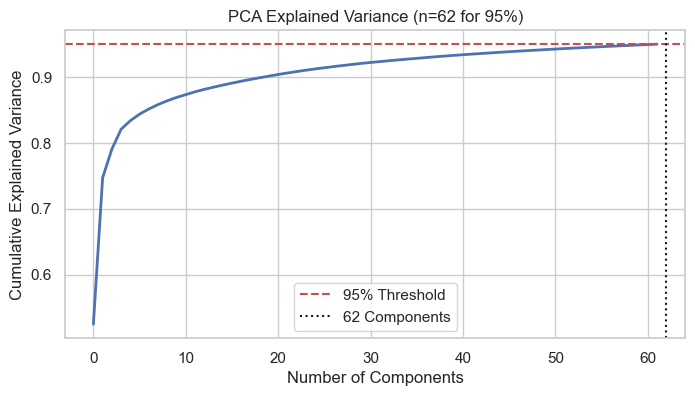

In [26]:
# Cell 4. PCA 적용 (n_components=0.95)

print("[INFO] Fitting PCA (keeping 95% variance)...")

# 99% 분산을 유지하도록 주성분 개수 자동 결정
pca = PCA(n_components=0.95, random_state=SEED)

# Train 데이터로 학습
pca.fit(X_train_scaled)

# 변환 (Transform)
X_train_pca = pca.transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)

n_components = pca.n_components_
explained_var = np.sum(pca.explained_variance_ratio_)

print(f"[OK] PCA Finished.")
print(f"  Original features : {X_train_raw.shape[1]}")
print(f"  Reduced features  : {n_components}")
print(f"  Explained variance: {explained_var:.4f}")
print(f"  X_train_pca shape : {X_train_pca.shape}")
print(f"  X_val_pca shape   : {X_val_pca.shape}")

# ------------------------------------------------------------
# 시각화: 설명된 분산 비율 (Elbow Plot)
# ------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Explained Variance (n={n_components} for 95%)')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.axvline(x=n_components, color='k', linestyle=':', label=f'{n_components} Components')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Cell 5. 저장 (PCA된 데이터 + 기존 레이블)

print(f"[INFO] Saving to {OUT_NPZ} ...")

np.savez_compressed(
    OUT_NPZ,
    # PCA Features
    X_train=X_train_pca.astype(np.float32),
    X_val=X_val_pca.astype(np.float32),
    
    # Labels (Pass-through)
    y_digit_train=y_digit_train,
    y_digit_val=y_digit_val,
    y_fg_train=y_fg_train,
    y_fg_val=y_fg_val,
    y_bg_train=y_bg_train,
    y_bg_val=y_bg_val,
    
    # Metadata
    source_train=source_train,
    source_val=source_val,
    pca_components=n_components,
    explained_variance=explained_var
)

print("[DONE] File saved successfully.")

[INFO] Saving to c:\src\colored-mnist-classification\data\processed\colored_mnist\colored_mnist_100k_pca.npz ...
[DONE] File saved successfully.


In [28]:
# Cell 5. PCA 처리된 데이터 로드

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.neighbors import KNeighborsClassifier

# 시각화 설정
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

# 랜덤 시드
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("[OK] Libraries imported.")

cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    BASE_DIR = os.path.dirname(cwd)
else:
    BASE_DIR = cwd

NPZ_PATH = os.path.join(
    BASE_DIR, "data", "processed", "colored_mnist", "colored_mnist_100k_pca.npz"
)

# 결과 저장 경로
RESULTS_METRICS_DIR = os.path.join(BASE_DIR, "results", "metrics")
RESULTS_FIGURES_DIR = os.path.join(BASE_DIR, "results", "figures")
os.makedirs(RESULTS_METRICS_DIR, exist_ok=True)
os.makedirs(RESULTS_FIGURES_DIR, exist_ok=True)

print(f"[INFO] NPZ_PATH: {NPZ_PATH}")

## load data
if not os.path.exists(NPZ_PATH):
    raise FileNotFoundError(f"[ERROR] File not found: {NPZ_PATH}")

data = np.load(NPZ_PATH)
print("[OK] Loaded npz keys:", list(data.keys()))

X_train = data["X_train"].astype(np.float32)
X_val   = data["X_val"].astype(np.float32)

# Labels
y_digit_train = data["y_digit_train"]
y_digit_val   = data["y_digit_val"]
y_fg_train    = data["y_fg_train"]
y_fg_val      = data["y_fg_val"]
y_bg_train    = data["y_bg_train"]
y_bg_val      = data["y_bg_val"]

# Source info (optional EDA)
source_train = data["source_train"]
source_val   = data["source_val"]

print(f"[INFO] X_train: {X_train.shape}, X_val: {X_val.shape}")

[OK] Libraries imported.
[INFO] NPZ_PATH: c:\src\colored-mnist-classification\data\processed\colored_mnist\colored_mnist_100k_pca.npz
[OK] Loaded npz keys: ['X_train', 'X_val', 'y_digit_train', 'y_digit_val', 'y_fg_train', 'y_fg_val', 'y_bg_train', 'y_bg_val', 'source_train', 'source_val', 'pca_components', 'explained_variance']
[INFO] X_train: (80000, 62), X_val: (20000, 62)


In [29]:
# Cell 6 시각화 코드

def reconstruct_images(X_flat, n_samples=16):
    """Flatten된 이미지를 시각화를 위해 다시 (28, 28, 3)으로 변환"""
    # IMG_SHAPE는 (28, 28, 3)으로 가정
    IMG_SHAPE = (28, 28, 3)
    n = min(n_samples, X_flat.shape[0])
    idxs = np.random.choice(X_flat.shape[0], size=n, replace=False)
    imgs = X_flat[idxs].reshape(n, *IMG_SHAPE)
    return imgs, idxs

def plot_sample_images(X_flat, y, title, n_samples=16):
    """샘플 이미지 그리드 출력"""
    imgs, idxs = reconstruct_images(X_flat, n_samples=n_samples)
    n = imgs.shape[0]
    cols = min(8, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 1.5, rows * 1.5))
    for i, (img, idx) in enumerate(zip(imgs, idxs)):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img / 255.0)
        ax.axis("off")
        ax.set_title(str(int(y[idx])), fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_label_distribution_2way(y_train, y_val, task_name):
    """Train/Val 레이블 분포 비교 그래프"""
    def counts(y):
        return pd.Series(y).value_counts().sort_index()

    train_c = counts(y_train)
    val_c   = counts(y_val)

    df = pd.DataFrame({
        "label": train_c.index,
        "train": train_c.values,
        "val":   val_c.values,
    })

    print(f"\n[EDA] Label distribution for task = {task_name}")
    print(df)

    x = np.arange(len(df["label"]))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width / 2, df["train"], width=width, label="train")
    plt.bar(x + width / 2, df["val"],   width=width, label="val")

    plt.xticks(x, df["label"])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(f"Label distribution per split ({task_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_source_distribution(source_train, source_val):
    """데이터 소스(raw/deskew/font/geom) 분포 비교"""
    train_counts = pd.Series(source_train).value_counts().sort_index()
    val_counts   = pd.Series(source_val).value_counts().sort_index()

    df = pd.DataFrame({
        "source": train_counts.index,
        "train": train_counts.values,
        "val":   val_counts.reindex(train_counts.index).values,
    })

    print("\n[EDA] Source distribution (train/val):")
    print(df)

    x = np.arange(len(df["source"]))
    width = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - width / 2, df["train"], width=width, label="train")
    plt.bar(x + width / 2, df["val"],   width=width, label="val")
    plt.xticks(x, df["source"])
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.title("Source distribution per split")
    plt.legend()
    plt.tight_layout()
    plt.show()

def compute_metrics(y_true, y_pred, average="macro"):
    """정확도, 정밀도, 재현율, F1 계산"""
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, zero_division=0
    )
    return acc, prec, rec, f1

def plot_confusion_matrix(y_true, y_pred, classes, title, save_path=None):
    """혼동 행렬(Confusion Matrix) 시각화"""
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=classes,
        yticklabels=classes,
        cmap="YlGnBu",
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

def show_prediction_examples(model_name, pipeline, X, y_true, task_name, n=12):
    """예측 결과 예시 이미지 출력"""
    # IMG_SHAPE는 (28, 28, 3)으로 가정
    IMG_SHAPE = (28, 28, 3)
    n = min(n, X.shape[0])
    idxs = np.random.choice(X.shape[0], size=n, replace=False)
    X_sample = X[idxs]
    y_sample_true = y_true[idxs]
    y_sample_pred = pipeline.predict(X_sample)

    imgs = X_sample.reshape(n, *IMG_SHAPE)

    cols = min(6, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2, rows * 2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(imgs[i] / 255.0)
        ax.axis("off")
        ax.set_title(
            f"T:{int(y_sample_true[i])} / P:{int(y_sample_pred[i])}",
            fontsize=8,
        )
    plt.suptitle(f"{task_name} - {model_name}: prediction examples", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_feature_importance_heatmap(feature_importances, title, save_path=None):
    """(KNN에서는 안 쓰지만) 트리 모델용 특성 중요도 시각화"""
    if feature_importances.shape[0] != 28 * 28 * 3:
        return
    imp_3d = feature_importances.reshape(28, 28, 3)
    imp_2d = imp_3d.mean(axis=2)

    plt.figure(figsize=(4, 4))
    sns.heatmap(imp_2d, cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

In [30]:

# Cell 7. Task 설정

TASK_LABEL_INFO = {
    "digit": {
        "y_train": y_digit_train,
        "y_val":   y_digit_val,
        "task_desc": "Digit classification (0-9)",
        "classes": [str(i) for i in range(10)]
    },
    "fg": {
        "y_train": y_fg_train,
        "y_val":   y_fg_val,
        "task_desc": "Foreground color (ROYGBIV)",
        "classes": ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]
    },
    "bg": {
        "y_train": y_bg_train,
        "y_val":   y_bg_val,
        "task_desc": "Background color (ROYGBIV)",
        "classes": ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]
    },
}

# 실행할 Task 목록
ACTIVE_TASKS = ["digit", "fg", "bg"]



In [31]:
# Cell 8. 모델 설정

BASE_MODELS = {
    "knn": KNeighborsClassifier(
        n_neighbors=5,
        weights="distance",  # 거리에 따른 가중치
        p=2,                 # 유클리드 거리
        metric="minkowski",
        n_jobs=-1
    ),
}

# only knn
ACTIVE_MODELS = ["knn"] 

# 스케일링 필요 여부 (KNN은 필수!)
NEEDS_SCALING = {"knn": True}

# GridSearch 사용 여부 False. PCA 된거로 확인할 거임.
USE_GRIDSEARCH = {"knn": True}

#  GridSearch 파라미터 범위
PARAM_GRIDS = {
    "knn": {
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2],
    }
}

def build_pipeline(model_name, base_estimator):
    """StandardScaler + Model 파이프라인 생성"""
    if NEEDS_SCALING.get(model_name, False):
        # KNN은 스케일링이 매우 중요하므로 Scaler를 앞에 붙입니다.
        return Pipeline([("scaler", StandardScaler()), ("clf", base_estimator)])
    else:
        return Pipeline([("clf", base_estimator)])


### TASK: digit (Digit classification (0-9))

[TRAIN] Training knn...
  -> Running GridSearch for knn...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  -> Best params: {'clf__n_neighbors': 5, 'clf__p': 2, 'clf__weights': 'distance'}
[DONE] Training finished.

[EVAL] digit - knn
  Accuracy : 0.9261
  F1-score : 0.9259


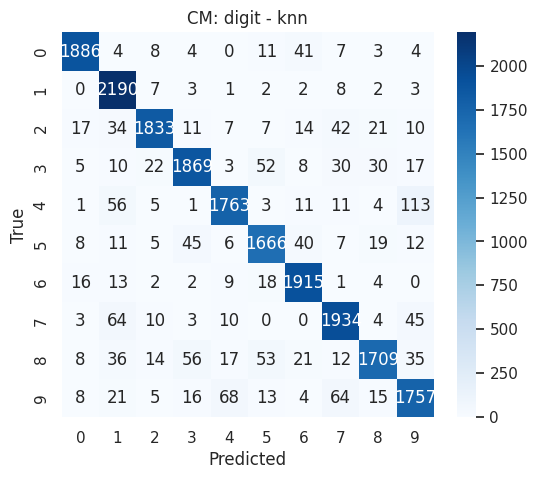


### TASK: fg (Foreground color (ROYGBIV))

[TRAIN] Training knn...
  -> Running GridSearch for knn...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  -> Best params: {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'distance'}
[DONE] Training finished.

[EVAL] fg - knn
  Accuracy : 0.8816
  F1-score : 0.8810


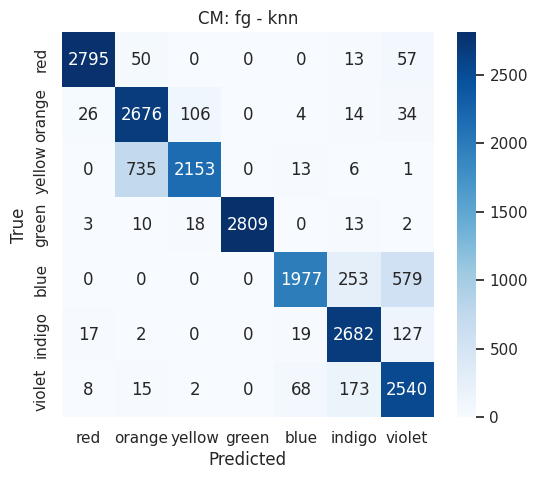


### TASK: bg (Background color (ROYGBIV))

[TRAIN] Training knn...
  -> Running GridSearch for knn...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  -> Best params: {'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'}
[DONE] Training finished.

[EVAL] bg - knn
  Accuracy : 0.9120
  F1-score : 0.9113


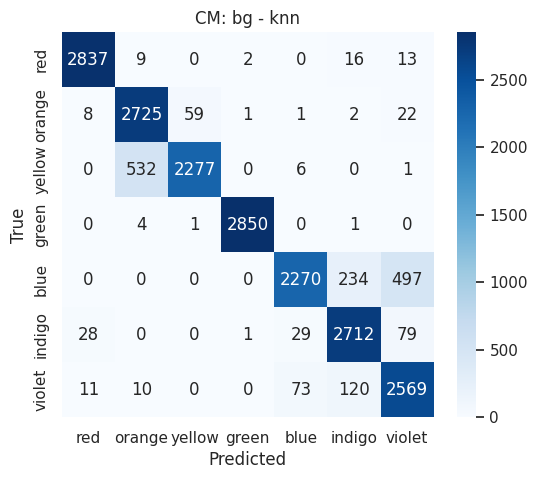



=== Final Results ===
    task model  accuracy  f1_score
0  digit   knn    0.9261  0.925946
1     fg   knn    0.8816  0.880980
2     bg   knn    0.9120  0.911295


In [32]:

# Cell 9. Main Loop

all_results = []

for task_name in ACTIVE_TASKS:
    info = TASK_LABEL_INFO[task_name]
    y_train_task = info["y_train"]
    y_val_task   = info["y_val"]
    class_names  = info["classes"]
    
    print(f"\n{'='*60}")
    print(f"### TASK: {task_name} ({info['task_desc']})")
    print(f"{'='*60}")

    for model_name in ACTIVE_MODELS:
        print(f"\n[TRAIN] Training {model_name}...")
        
        # 파이프라인 빌드
        base_est = BASE_MODELS[model_name]
        pipe = build_pipeline(model_name, base_est)
        
        # GridSearch or fit
        if USE_GRIDSEARCH.get(model_name, False):
            print(f"  -> Running GridSearch for {model_name}...")
            grid = GridSearchCV(
                pipe, 
                PARAM_GRIDS[model_name], 
                cv=3, 
                n_jobs=-1, 
                scoring="accuracy",
                verbose=1
            )
            grid.fit(X_train, y_train_task)
            best_model = grid.best_estimator_
            print("  -> Best params:", grid.best_params_)
        else:
            # 단순 학습
            pipe.fit(X_train, y_train_task)
            best_model = pipe
            
        print("[DONE] Training finished.")
        
        # 평가 (Validation)
        y_pred = best_model.predict(X_val)
        
        acc = accuracy_score(y_val_task, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_val_task, y_pred, average="weighted")
        
        print(f"\n[EVAL] {task_name} - {model_name}")
        print(f"  Accuracy : {acc:.4f}")
        print(f"  F1-score : {f1:.4f}")
        
        # Confusion Matrix 시각화
        cm = confusion_matrix(y_val_task, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f"CM: {task_name} - {model_name}")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()
        
        # 결과 저장
        all_results.append({
            "task": task_name,
            "model": model_name,
            "accuracy": acc,
            "f1_score": f1
        })

# 최종 요약 출력
print("\n\n=== Final Results ===")
print(pd.DataFrame(all_results))